In [61]:
import torch
import torch.nn as nn
import math

# LayerNormalization

In [62]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [63]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [64]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)

In [65]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

In [66]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)


In [67]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

In [68]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [69]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [70]:
import torch
import torch.nn as nn
import math

# Reuse the existing components: InputEmbeddings, PositionalEncoding, LayerNormalization, etc.
# Modify only the components necessary for classification.

class TransformerEncoderClassifier(nn.Module):
    def __init__(self, 
                 src_vocab_size: int, 
                 src_seq_len: int, 
                 d_model: int, 
                 N: int, 
                 h: int, 
                 d_ff: int, 
                 num_classes: int, 
                 dropout: float = 0.1):
        super().__init__()
        # Input embedding and positional encoding
        self.src_embed = InputEmbeddings(d_model, src_vocab_size)
        self.src_pos = PositionalEncoding(d_model, src_seq_len, dropout)

        # Transformer encoder
        encoder_blocks = []
        for _ in range(N):
            self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
            feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
            encoder_block = EncoderBlock(d_model, self_attention_block, feed_forward_block, dropout)
            encoder_blocks.append(encoder_block)
        self.encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, src, src_mask):
        # Embed and encode the input
        src = self.src_embed(src)  # (batch, seq_len, d_model)
        src = self.src_pos(src)    # (batch, seq_len, d_model)
        encoder_output = self.encoder(src, src_mask)  # (batch, seq_len, d_model)

        # Aggregate features for classification
        # Mean pooling over the sequence length
        pooled_output = encoder_output.mean(dim=1)  # (batch, d_model)

        # Classification
        return self.classifier(pooled_output)

# Utility to create masks
def create_padding_mask(input_tensor, pad_token_idx):
    return (input_tensor != pad_token_idx).unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, seq_len)

# Hyperparameters and training setup
# src_vocab_size = 20000  # Adjust based on your dataset's vocabulary size
# src_seq_len = 512       # Maximum sequence length for a paragraph
# d_model = 256           # Embedding size
# N = 6                   # Number of encoder layers
# h = 8                   # Number of attention heads
# d_ff = 1024             # Feedforward network size
# num_classes = 14        # Number of topic classes
# dropout = 0.1

# # Instantiate the model
# model = TransformerEncoderClassifier(
#     src_vocab_size=src_vocab_size,
#     src_seq_len=src_seq_len,
#     d_model=d_model,
#     N=N,
#     h=h,
#     d_ff=d_ff,
#     num_classes=num_classes,
#     dropout=dropout
# )

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Dummy training loop
# def train_model(model, train_loader, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         for batch in train_loader:
#             paragraphs, labels = batch
#             optimizer.zero_grad()
            
#             # Create masks (assuming 0 is the PAD token)
#             src_mask = create_padding_mask(paragraphs, pad_token_idx=0)
            
#             # Forward pass
#             outputs = model(paragraphs, src_mask)  # (batch, num_classes)
            
#             # Compute loss
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
        
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")



In [71]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn

In [72]:
data = pd.read_csv('D:/AI/S1_Y3/DL/Code/final/data.csv')
data 

,Paragraph,Topic
0,"Khoảng 6h30, thiếu niên ngụ xã Thượng Quận, th...",Thời sự
1,"Hai xe đối đầu tạo tiếng động mạnh, ba người đ...",Thời sự
2,Camera hành trình của ôtô đi trên đoạn đường đ...,Thời sự
3,Camera hành trình ghi lại vụ tai nạn sáng 6/12.,Thời sự
4,Đoạn đường xảy ra tai nạn không có dải phân cá...,Thời sự
...,...,...
29995,"Tiếc thay, đó cũng không phải lần cuối rắc rối...",Ý kiến
29996,"Ngày thắng kiện, tôi lặng lẽ về dọn đồ của mẹ ...",Ý kiến
29997,"Từ lúc hiểu ra điều đó, tôi đã hoàn toàn ""buôn...",Ý kiến
29998,"Hiện nay, nhiều người có cái nhìn khá phiến di...",Ý kiến


In [73]:
stop_words = pd.read_csv('D:/AI/S1_Y3/DL/Code/final/stopwords.csv')
stop_words

,stopwords
0,mà_thôi
1,tuy_có
2,đâu_như
3,quay_bước
4,hỏi_lại
...,...
1937,cái_họ
1938,hết
1939,lại
1940,thế_thế


In [74]:
from pyvi.ViTokenizer import tokenize
import re, os, string
import pandas as pd

def clean_text(text):
    text = re.sub('<.*?>', '', text).strip()
    text = re.sub('(\s)+', r'\1', text)
    return text

def normalize_text(text):
    listpunctuation = string.punctuation.replace('_', '')
    for i in listpunctuation:
        text = text.replace(i, ' ')
    return text.lower()

# list stopwords


def remove_stopword(text):
    pre_text = []
    words = text.split()
    for word in words:
        if word not in stop_words:
            pre_text.append(word)
    text2 = ' '.join(pre_text)

    return text2

def sentence_segment(text):
    sents = re.split("([.?!])?[\n]+|[.?!] ", text)
    return sents


def word_segment(sent):
    sent = tokenize(sent)
    return sent

def preprocess_text(text):
    """Full preprocessing pipeline for a single text."""
    text = clean_text(text)
    text = normalize_text(text)
    text = remove_stopword(text)
    return text

def convert_paragraphs_to_list(dataframe, text_column):
    """Convert the content of the specified text column to a list of processed strings."""
    processed_texts = dataframe[text_column].apply(preprocess_text).tolist()
    return processed_texts



In [75]:
for i in range(len(data)):
    content = clean_text(data.loc[i, 'Paragraph'])
    sents = sentence_segment(content)
    for sent in sents:
        if(sent != None):
            sent = word_segment(sent)
            sent = remove_stopword(normalize_text(sent))
            if(len(sent.split()) > 1):
                data.loc[i, 'Paragraph'] = sent


In [76]:
from collections import Counter
def build_vocab(tokenized_texts, min_freq=1, special_tokens=["<pad>", "<unk>"]):
    
    # Flatten the list of tokenized texts and count token frequencies
    all_tokens = [token for text in tokenized_texts for token in text.split()]
    token_counts = Counter(all_tokens)

    # Filter tokens by minimum frequency
    filtered_tokens = {token: count for token, count in token_counts.items() if count >= min_freq}

    # Create the vocabulary with special tokens first
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    vocab.update({token: idx + len(vocab) for idx, token in enumerate(filtered_tokens.keys())})

    return vocab, filtered_tokens


In [77]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np


In [79]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def encode(self, text):
        tokens = [self.vocab.get(token, self.vocab["<unk>"]) for token in text.split()]
        tokens = tokens[:self.max_len]
        tokens += [self.vocab["<pad>"]] * (self.max_len - len(tokens))
        return torch.tensor(tokens, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_text = self.encode(text)
        return encoded_text, torch.tensor(label, dtype=torch.long)

In [86]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

if __name__ == "__main__":
    # Dummy data loader
    texts = convert_paragraphs_to_list(data, text_column="Paragraph")

    unique_topics = data['Topic'].unique()
    topic_to_id = {topic: idx for idx, topic in enumerate(unique_topics)} 

    data['Topic'] = data['Topic'].map(topic_to_id)
    labels = data['Topic'].tolist()
    vocab, token_freqs = build_vocab(texts)

    # Hyperparameters and training setup
    max_len = 15
    src_vocab_size = 30000  # Adjust based on your dataset's vocabulary size
    src_seq_len = 512       # Maximum sequence length for a paragraph
    d_model = 256           # Embedding size
    N = 6                   # Number of encoder layers
    h = 8                   # Number of attention heads
    d_ff = 1024             # Feedforward network size
    num_classes = 15        # Number of topic classes
    dropout = 0.1           # Dropout rate
    batch_size = 64         # Number of samples per batch
    epochs = 20             # Number of epochs
    learning_rate = 0.001   # Learning rate

    dataset = TextDataset(texts, labels, vocab, max_len)

    # Split the data into train, validation, and test sets (80% train, 10% validation, 10% test)
    train_indices, test_val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, random_state=42)

    # Create subsets for train, validation, and test
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    # DataLoaders for train, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Instantiate the model
    model = TransformerEncoderClassifier(
        src_vocab_size=src_vocab_size,
        src_seq_len=src_seq_len,
        d_model=d_model,
        N=N,
        h=h,
        d_ff=d_ff,
        num_classes=num_classes,
        dropout=dropout
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Dummy training loop
    def train_model(model, train_loader, val_loader, num_epochs=10):
        model.train()
        for epoch in range(num_epochs):
            # Training
            for batch in train_loader:
                paragraphs, labels = batch
                optimizer.zero_grad()
                
                # Create masks (assuming 0 is the PAD token)
                src_mask = create_padding_mask(paragraphs, pad_token_idx=0)
                
                # Forward pass
                outputs = model(paragraphs, src_mask)  # (batch, num_classes)
                
                # Compute loss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            accuracy = lambda y_pred, y_true: (y_pred.argmax(1) == y_true).float().mean().item()
            
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy(outputs, labels):.2f}")
            
            # Validation step
            model.eval()
            val_loss = 0
            val_accuracy = 0
            with torch.no_grad():
                for batch in val_loader:
                    paragraphs, labels = batch
                    src_mask = create_padding_mask(paragraphs, pad_token_idx=0)
                    outputs = model(paragraphs, src_mask)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_accuracy += accuracy(outputs, labels)

            val_loss /= len(val_loader)
            val_accuracy /= len(val_loader)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")
            model.train()

    # Train the model
    train_model(model, train_loader, val_loader, num_epochs=epochs)


Epoch 1/20, Loss: 1.7177, Accuracy: 0.42
Validation Loss: 1.6180, Validation Accuracy: 0.51
Epoch 2/20, Loss: 1.3592, Accuracy: 0.58
Validation Loss: 1.3811, Validation Accuracy: 0.59
Epoch 3/20, Loss: 1.3963, Accuracy: 0.56
Validation Loss: 1.3629, Validation Accuracy: 0.61
Epoch 4/20, Loss: 0.6010, Accuracy: 0.83
Validation Loss: 1.4332, Validation Accuracy: 0.61
Epoch 5/20, Loss: 0.5777, Accuracy: 0.77
Validation Loss: 1.5142, Validation Accuracy: 0.63
Epoch 6/20, Loss: 0.4653, Accuracy: 0.84
Validation Loss: 1.6395, Validation Accuracy: 0.64
Epoch 7/20, Loss: 0.3974, Accuracy: 0.88
Validation Loss: 1.8348, Validation Accuracy: 0.63
Epoch 8/20, Loss: 0.2917, Accuracy: 0.89
Validation Loss: 1.8909, Validation Accuracy: 0.63
Epoch 9/20, Loss: 0.2835, Accuracy: 0.91
Validation Loss: 1.9812, Validation Accuracy: 0.64
Epoch 10/20, Loss: 0.2690, Accuracy: 0.92
Validation Loss: 2.0113, Validation Accuracy: 0.64
Epoch 11/20, Loss: 0.1715, Accuracy: 0.95
Validation Loss: 2.1276, Validation A

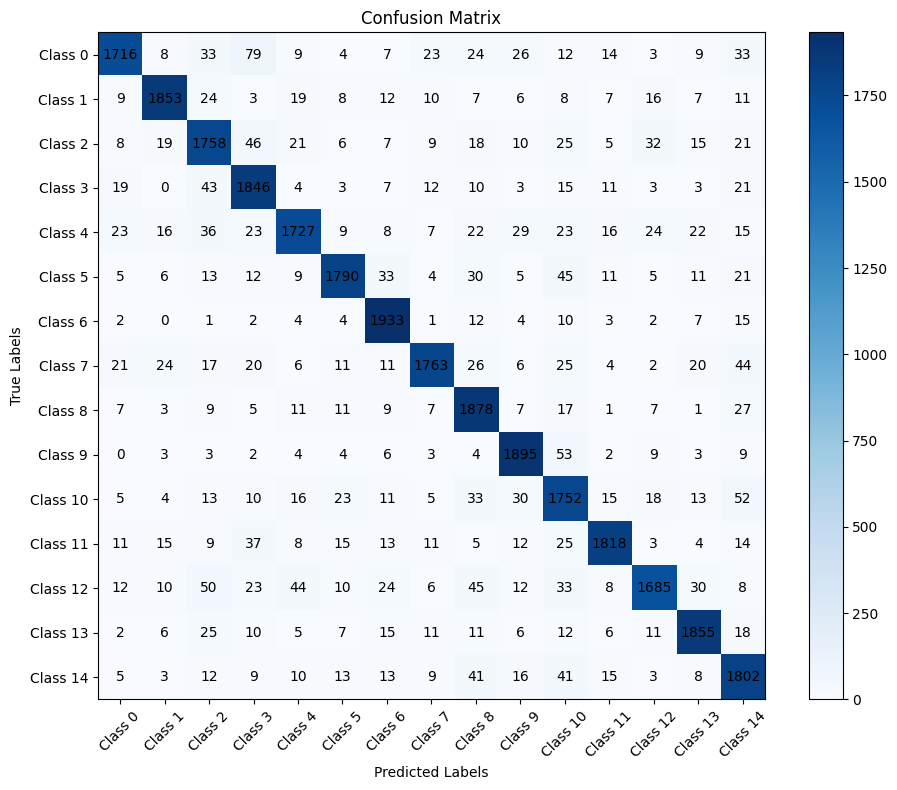

Class 0: Precision=0.93, Recall=0.86, F1-Score=0.89
Class 1: Precision=0.94, Recall=0.93, F1-Score=0.93
Class 2: Precision=0.86, Recall=0.88, F1-Score=0.87
Class 3: Precision=0.87, Recall=0.92, F1-Score=0.89
Class 4: Precision=0.91, Recall=0.86, F1-Score=0.89
Class 5: Precision=0.93, Recall=0.90, F1-Score=0.91
Class 6: Precision=0.92, Recall=0.97, F1-Score=0.94
Class 7: Precision=0.94, Recall=0.88, F1-Score=0.91
Class 8: Precision=0.87, Recall=0.94, F1-Score=0.90
Class 9: Precision=0.92, Recall=0.95, F1-Score=0.93
Class 10: Precision=0.84, Recall=0.88, F1-Score=0.86
Class 11: Precision=0.94, Recall=0.91, F1-Score=0.92
Class 12: Precision=0.92, Recall=0.84, F1-Score=0.88
Class 13: Precision=0.92, Recall=0.93, F1-Score=0.93
Class 14: Precision=0.85, Recall=0.90, F1-Score=0.88


In [87]:
import matplotlib.pyplot as plt
import numpy as np

test_loader = DataLoader(dataset, batch_size=1, shuffle=True)
y_true = [] 
y_pred = []

cm = torch.zeros(num_classes, num_classes, dtype=torch.int32)

for texts, labels in test_loader:
    outputs = model(texts, create_padding_mask(texts, pad_token_idx=0))
    predictions = torch.argmax(outputs, dim=1)
    y_true.append(labels.item())
    y_pred.append(predictions.item())


for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

# Step 2: Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm.numpy(), interpolation='nearest', cmap='Blues')
plt.colorbar()

# Add labels
classes = [f"Class {i}" for i in range(num_classes)]
plt.xticks(ticks=np.arange(num_classes), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(num_classes), labels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Annotate each cell with the count
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j].item(), ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

# Step 3: Compute metrics for each class (Precision, Recall, F1-score)
def compute_metrics(cm):
    metrics = {}
    for i in range(num_classes):
        tp = cm[i, i].item()
        fp = cm[:, i].sum().item() - tp
        fn = cm[i, :].sum().item() - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        metrics[f"Class {i}"] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }
    return metrics

metrics = compute_metrics(cm)

# Print metrics for each class
for cls, m in metrics.items():
    print(f"{cls}: Precision={m['Precision']:.2f}, Recall={m['Recall']:.2f}, F1-Score={m['F1-Score']:.2f}")